# Análise de Transformador Monofásico no Google Colab

Este notebook realiza a análise completa de um transformador monofásico, dividido em duas partes principais, conforme os desafios propostos:

* **Desafio 3:** Determinação dos parâmetros do circuito equivalente do transformador a partir dos dados dos ensaios de circuito aberto e curto-circuito.
* **Desafio 4:** Análise de desempenho (regulação de tensão e eficiência) e plotagem do diagrama fasorial do transformador sob uma condição de carga específica.

Execute as células em ordem para obter o resultado completo.

In [2]:
# Bloco de Configuração: Imports e Definição das Classes

import numpy as np
import matplotlib.pyplot as plt
import cmath
from matplotlib.patches import Arc

class AnaliseCarregamentoTransformador:
    """
    Realiza análise de desempenho do transformador sob diferentes condições de carga,
    incluindo cálculo de regulação de tensão e eficiência.
    """

    def __init__(self, parametros_transformador, fator_potencia=0.92, tipo_fator_potencia='atrasado', potencia_carga_kVA=None):
        self.parametros = parametros_transformador
        self.potencia_nominal = self.parametros['potencia_nominal']
        self.tensao_primaria_nominal = self.parametros['tensao_alta']
        self.tensao_secundaria_nominal = self.parametros['tensao_baixa']
        self.impedancia_equivalente = complex(
            self.parametros['resistencia_equivalente_alta'],
            self.parametros['reatancia_equivalente_alta']
        )
        self.fator_potencia = fator_potencia
        self.tipo_fator_potencia = tipo_fator_potencia.lower()
        self.potencia_carga = potencia_carga_kVA * 1e3 if potencia_carga_kVA is not None else self.potencia_nominal
        self.relacao_transformacao = self.parametros['relacao_transformacao']

        if self.tipo_fator_potencia not in ['atrasado', 'adiantado']:
            raise ValueError("tipo_fator_potencia deve ser 'atrasado' ou 'adiantado'")

    def calcular_corrente_secundaria(self):
        if not -1.0 <= self.fator_potencia <= 1.0:
            raise ValueError(f"Fator de Potência Inválido: {self.fator_potencia}. O valor deve estar entre -1.0 e 1.0.")
        modulo_corrente = self.potencia_carga / self.tensao_secundaria_nominal
        angulo = np.arccos(self.fator_potencia)
        if self.tipo_fator_potencia == 'atrasado':
            angulo = -angulo
        return cmath.rect(modulo_corrente, angulo)

    def calcular_tensao_sem_carga(self):
        impedancia_eq_baixa = self.impedancia_equivalente / (self.relacao_transformacao**2)
        corrente_secundaria = self.calcular_corrente_secundaria()
        tensao_plena_carga = self.tensao_secundaria_nominal
        return tensao_plena_carga + impedancia_eq_baixa * corrente_secundaria

    def calcular_regulacao_tensao(self):
        tensao_sem_carga = self.calcular_tensao_sem_carga()
        tensao_plena_carga = self.tensao_secundaria_nominal
        return (abs(tensao_sem_carga) - tensao_plena_carga) / tensao_plena_carga * 100

    def calcular_eficiencia(self):
        potencia_saida = self.potencia_carga * self.fator_potencia
        corrente_secundaria_modulo = self.potencia_carga / self.tensao_secundaria_nominal
        resistencia_eq_baixa = self.impedancia_equivalente.real / (self.relacao_transformacao**2)
        perdas_cobre = resistencia_eq_baixa * (corrente_secundaria_modulo ** 2)
        resistencia_nucleo_baixa = self.parametros['resistencia_nucleo_baixa']
        perdas_nucleo = (self.tensao_secundaria_nominal ** 2) / resistencia_nucleo_baixa
        potencia_entrada = potencia_saida + perdas_cobre + perdas_nucleo
        if potencia_entrada == 0:
            return 0
        return (potencia_saida / potencia_entrada) * 100

    def plotar_diagrama_fasorial(self):
        tensao_sec_vazio = self.calcular_tensao_sem_carga()
        corrente_sec = self.calcular_corrente_secundaria()
        tensao_sec_carga = complex(self.tensao_secundaria_nominal, 0)
        impedancia_eq_baixa = self.impedancia_equivalente / (self.relacao_transformacao**2)
        queda_resistiva = impedancia_eq_baixa.real * corrente_sec
        queda_indutiva = 1j * impedancia_eq_baixa.imag * corrente_sec
        fator_escala_corrente = 5
        origem = np.array([0, 0])
        v_carga_xy = np.array([tensao_sec_carga.real, tensao_sec_carga.imag])
        i_sec_xy = np.array([corrente_sec.real, corrente_sec.imag]) * fator_escala_corrente
        queda_r_xy = np.array([queda_resistiva.real, queda_resistiva.imag])
        queda_x_xy = np.array([queda_indutiva.real, queda_indutiva.imag])
        v_vazio_xy = np.array([tensao_sec_vazio.real, tensao_sec_vazio.imag])
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        plt.quiver(*origem, *v_carga_xy, angles='xy', scale_units='xy', scale=1, color='blue', width=0.005, label=f'$V_2$ (carga) = {abs(tensao_sec_carga):.1f} V')
        plt.quiver(*origem, *i_sec_xy, angles='xy', scale_units='xy', scale=1, color='orange', width=0.005, label=f'$I_2$ (x{fator_escala_corrente}) = {abs(corrente_sec):.1f} A')
        plt.quiver(*origem, *v_vazio_xy, angles='xy', scale_units='xy', scale=1, color='green', width=0.005, label=f'$V_2$ (vazio) = {abs(tensao_sec_vazio):.1f} V')
        plt.quiver(*v_carga_xy, *queda_r_xy, angles='xy', scale_units='xy', scale=1, color='red', width=0.003, label='$R_{eq} \cdot I_2$')
        plt.quiver(*(v_carga_xy + queda_r_xy), *queda_x_xy, angles='xy', scale_units='xy', scale=1, color='purple', width=0.003, label='$jX_{eq} \cdot I_2$')
        if abs(corrente_sec) > 0:
            angulo_fp_rad = cmath.phase(corrente_sec)
            angulo_fp_deg = np.degrees(angulo_fp_rad)
            raio = abs(v_carga_xy[0]) * 0.4
            theta1, theta2 = (angulo_fp_deg, 0) if angulo_fp_deg < 0 else (0, angulo_fp_deg)
            arco = Arc(origem, 2*raio, 2*raio, angle=0, theta1=theta1, theta2=theta2, color='k', linestyle='--')
            ax.add_patch(arco)
            angulo_texto_rad = angulo_fp_rad / 2
            plt.text(raio * np.cos(angulo_texto_rad) * 1.1, raio * np.sin(angulo_texto_rad) * 1.1, f'$\\phi = {abs(angulo_fp_deg):.1f}^\\circ$', fontsize=12)
        limite_max = abs(tensao_sec_vazio) * 1.2
        plt.xlim(-limite_max, limite_max)
        plt.ylim(-limite_max, limite_max)
        plt.axhline(0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(0, color='k', linestyle='--', alpha=0.3)
        plt.grid(True, linestyle='--', alpha=0.5)
        angulo_graus_carga = np.degrees(np.arccos(self.fator_potencia))
        tipo_carga_str = "Indutiva" if self.tipo_fator_potencia == 'atrasado' else "Capacitiva"
        plt.title(f'Diagrama Fasorial - Carga {tipo_carga_str} (FP={self.fator_potencia}, $\\phi={angulo_graus_carga:.1f}^\\circ$)')
        plt.xlabel('Componente Real (V)')
        plt.ylabel('Componente Imaginária (V)')
        plt.legend(loc='best')
        plt.gca().set_aspect('equal', adjustable='box')
        return plt

class AnaliseTransformadorMonofasico:
    """
    Determina parâmetros do transformador a partir de ensaios
    de circuito aberto e curto-circuito.
    """
    def __init__(self, tensao_ca, corrente_ca, potencia_ca, tensao_cc, corrente_cc, potencia_cc,
                 tensao_baixa, tensao_alta, frequencia=60):
        self.tensao_ca, self.corrente_ca, self.potencia_ca = tensao_ca, corrente_ca, potencia_ca
        self.tensao_cc, self.corrente_cc, self.potencia_cc = tensao_cc, corrente_cc, potencia_cc
        self.tensao_baixa, self.tensao_alta = tensao_baixa, tensao_alta
        self.frequencia = frequencia
        self.relacao_transformacao = tensao_alta / tensao_baixa
        self.parametros = {}
        self.calcular_parametros()

    def calcular_parametros(self):
        resistencia_nucleo_baixa = (self.tensao_ca ** 2) / self.potencia_ca
        admitancia_ca = self.corrente_ca / self.tensao_ca
        condutancia_nucleo_baixa = 1 / resistencia_nucleo_baixa
        suscetancia_mag_baixa = np.sqrt(admitancia_ca**2 - condutancia_nucleo_baixa**2)
        reatancia_magnetizacao_baixa = 1 / suscetancia_mag_baixa
        resistencia_equivalente_alta = self.potencia_cc / (self.corrente_cc ** 2)
        impedancia_cc = self.tensao_cc / self.corrente_cc
        reatancia_equivalente_alta = np.sqrt(impedancia_cc**2 - resistencia_equivalente_alta**2)
        self.parametros = {
            'resistencia_nucleo_baixa': resistencia_nucleo_baixa,
            'reatancia_magnetizacao_baixa': reatancia_magnetizacao_baixa,
            'resistencia_equivalente_alta': resistencia_equivalente_alta,
            'reatancia_equivalente_alta': reatancia_equivalente_alta,
            'relacao_transformacao': self.relacao_transformacao,
            'tensao_baixa': self.tensao_baixa,
            'tensao_alta': self.tensao_alta,
            'potencia_nominal': self.tensao_alta * self.corrente_cc
        }

    def obter_parametros(self):
        return self.parametros

    def imprimir_parametros(self):
        params = self.obter_parametros()
        a = params['relacao_transformacao']
        print("\n" + "="*60)
        print("PARÂMETROS DO TRANSFORMADOR MONOFÁSICO")
        print("="*60)
        print("\n--- Parâmetros do Ramo de Excitação (Referidos ao Lado de Baixa) ---")
        print(f"Resistência de perdas no núcleo (Rc_BT): {params['resistencia_nucleo_baixa']:.2f} Ω")
        print(f"Reatância de magnetização (Xm_BT): {params['reatancia_magnetizacao_baixa']:.2f} Ω")
        print("\n--- Parâmetros Série Equivalentes (Referidos ao Lado de Alta) ---")
        print(f"Resistência equivalente série (Req_AT): {params['resistencia_equivalente_alta']:.2f} Ω")
        print(f"Reatância equivalente série (Xeq_AT): {params['reatancia_equivalente_alta']:.2f} Ω")
        res_nucleo_alta = params['resistencia_nucleo_baixa'] * a**2
        reat_mag_alta = params['reatancia_magnetizacao_baixa'] * a**2
        print(f"\n--- Parâmetros do Ramo de Excitação (Referidos ao Lado de Alta) ---")
        print(f"Resistência de perdas no núcleo (Rc_AT): {res_nucleo_alta/1000:.2f} kΩ")
        print(f"Reatância de magnetização (Xm_AT): {reat_mag_alta/1000:.2f} kΩ")
        print("\n--- Características Nominais ---")
        print(f"Relação de transformação (a): {params['relacao_transformacao']:.2f}")
        print(f"Potência nominal aparente (Sn): {params['potencia_nominal']/1000:.2f} kVA")

print("Ambiente configurado com sucesso! As classes estão prontas para serem usadas.")

Ambiente configurado com sucesso! As classes estão prontas para serem usadas.


## DESAFIO 3: Determinação dos Parâmetros do Transformador

Neste bloco, instanciamos a classe `AnaliseTransformadorMonofasico` com os dados de ensaio para um transformador de 10 kVA, 13200/240 V. O código calculará e imprimirá os parâmetros do circuito equivalente.

In [3]:
# Bloco de Execução do Desafio 3

print("=== INICIANDO DESAFIO 3: Determinação de Parâmetros ===")
transformador = AnaliseTransformadorMonofasico(
    tensao_ca=240,      # Tensão ensaio vazio Vca (V) - Lado BT
    corrente_ca=0.2,    # Corrente ensaio vazio Ica (A)
    potencia_ca=35,     # Potência ensaio vazio Pca (W)
    tensao_cc=528,      # Tensão ensaio curto Vcc (V) - Lado AT
    corrente_cc=0.757,  # Corrente ensaio curto Icc (A) - Nominal AT
    potencia_cc=120,    # Potência ensaio curto Pcc (W)
    tensao_baixa=240,   # Tensão nominal V_baixa (V)
    tensao_alta=13200   # Tensão nominal V_alta (V)
)
transformador.imprimir_parametros()

# Armazena os parâmetros calculados para usar no próximo desafio
parametros_calculados = transformador.obter_parametros()

print("\nFim do Desafio 3. Os parâmetros foram calculados e armazenados na variável 'parametros_calculados'.")

=== INICIANDO DESAFIO 3: Determinação de Parâmetros ===

PARÂMETROS DO TRANSFORMADOR MONOFÁSICO

--- Parâmetros do Ramo de Excitação (Referidos ao Lado de Baixa) ---
Resistência de perdas no núcleo (Rc_BT): 1645.71 Ω
Reatância de magnetização (Xm_BT): 1753.52 Ω

--- Parâmetros Série Equivalentes (Referidos ao Lado de Alta) ---
Resistência equivalente série (Req_AT): 209.41 Ω
Reatância equivalente série (Xeq_AT): 665.31 Ω

--- Parâmetros do Ramo de Excitação (Referidos ao Lado de Alta) ---
Resistência de perdas no núcleo (Rc_AT): 4978.29 kΩ
Reatância de magnetização (Xm_AT): 5304.41 kΩ

--- Características Nominais ---
Relação de transformação (a): 55.00
Potência nominal aparente (Sn): 9.99 kVA

Fim do Desafio 3. Os parâmetros foram calculados e armazenados na variável 'parametros_calculados'.


## DESAFIO 4: Análise de Carga, Regulação e Diagrama Fasorial

Utilizando os parâmetros calculados no bloco anterior, este bloco simula o comportamento do transformador alimentando uma carga de 8 kVA com fator de potência 0.7 indutivo. Ele calcula a regulação de tensão, a eficiência e plota o diagrama fasorial da operação.



=== INICIANDO DESAFIO 4: Análise de Desempenho Sob Carga ===

--- Resultados Operacionais ---
Regulação de tensão: 2.86%
Eficiência em carga: 98.04%

Gerando diagrama fasorial de operação sob carga...


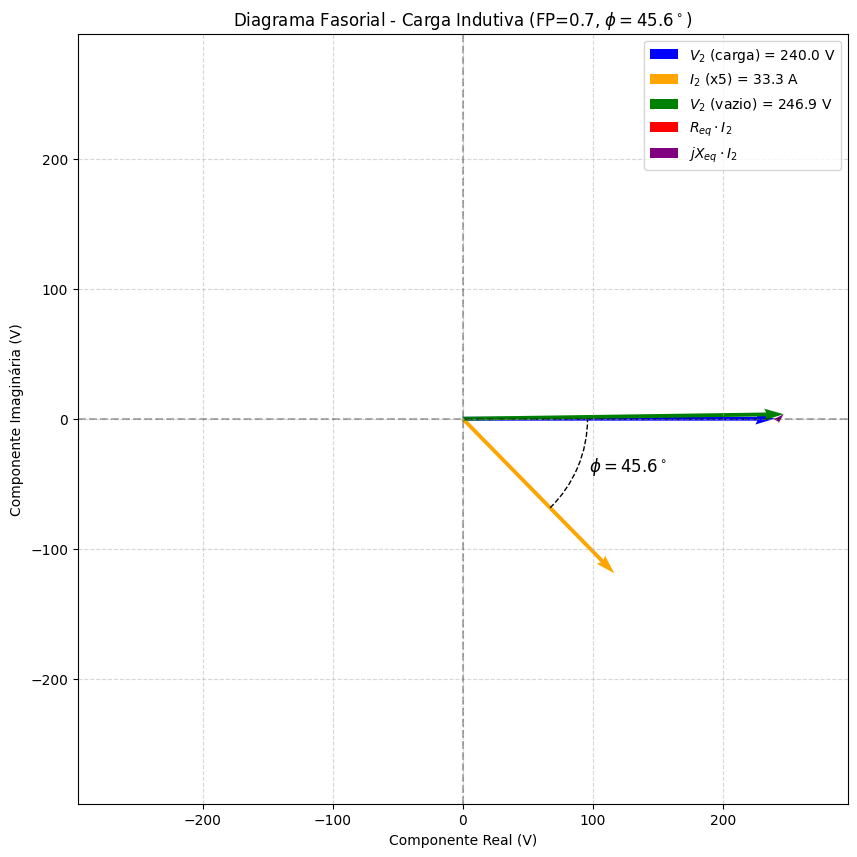

In [4]:
# Bloco de Execução do Desafio 4

print("\n\n=== INICIANDO DESAFIO 4: Análise de Desempenho Sob Carga ===")

# Verifica se a variável do desafio anterior existe antes de prosseguir
if 'parametros_calculados' in locals():
    transformador_carregado = AnaliseCarregamentoTransformador(
        parametros_transformador=parametros_calculados,
        fator_potencia=0.7,
        tipo_fator_potencia='atrasado',  # 'atrasado' para indutivo, 'adiantado' para capacitivo
        potencia_carga_kVA=8             # Potência da carga (8 kVA = 80% da nominal)
    )

    # Resultados operacionais
    print("\n--- Resultados Operacionais ---")
    print(f"Regulação de tensão: {transformador_carregado.calcular_regulacao_tensao():.2f}%")
    print(f"Eficiência em carga: {transformador_carregado.calcular_eficiencia():.2f}%")

    # Gera diagrama fasorial
    print("\nGerando diagrama fasorial de operação sob carga...")
    plot_diagrama = transformador_carregado.plotar_diagrama_fasorial()
    plt.show()

else:
    print("ERRO: Execute a célula do Desafio 3 primeiro para calcular os parâmetros do transformador.")